# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
#!pip install -r requirements.txt

In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [4]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

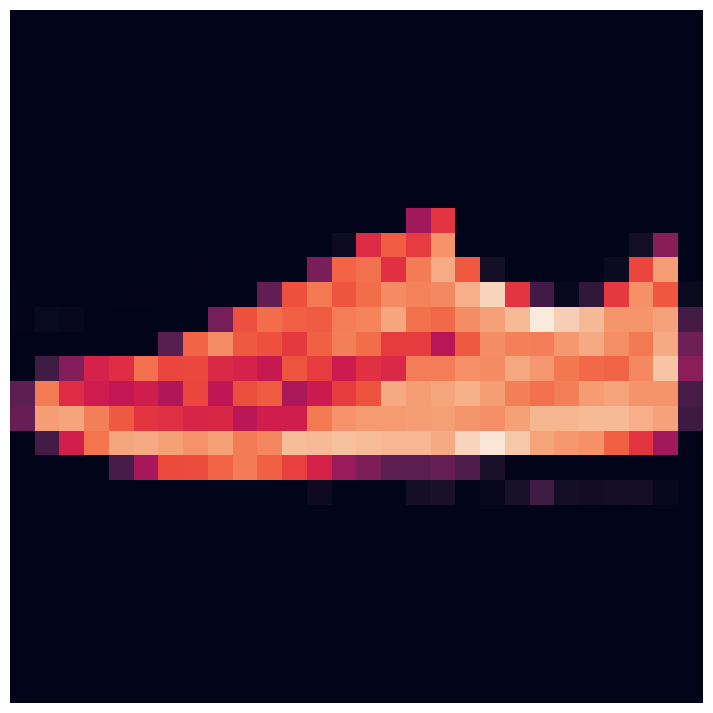

In [6]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

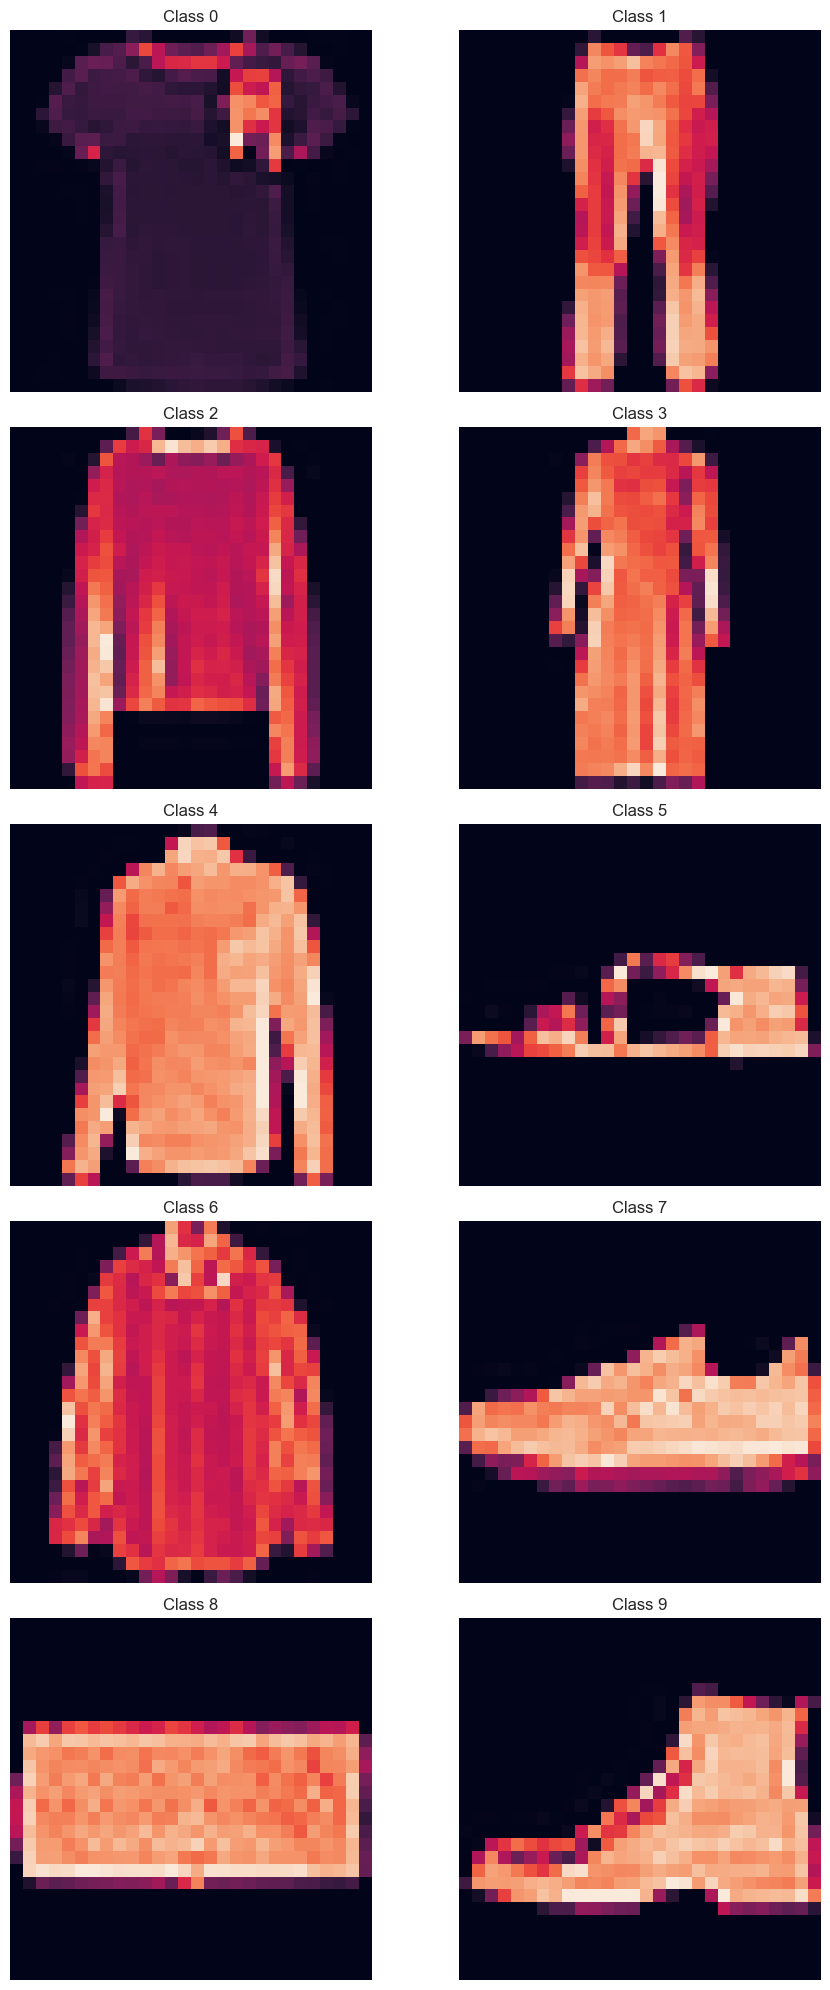

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

classes_done = set() 
for i in range(len(X)):
    label = int(y[i])
    if label not in classes_done:
        image = X[i].reshape(28, 28)

        axes[label // 2, label % 2].imshow(image)
        axes[label // 2, label % 2].set_title(f"Class {label}")
        axes[label // 2, label % 2].axis("off")

        classes_done.add(label)

plt.tight_layout()
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

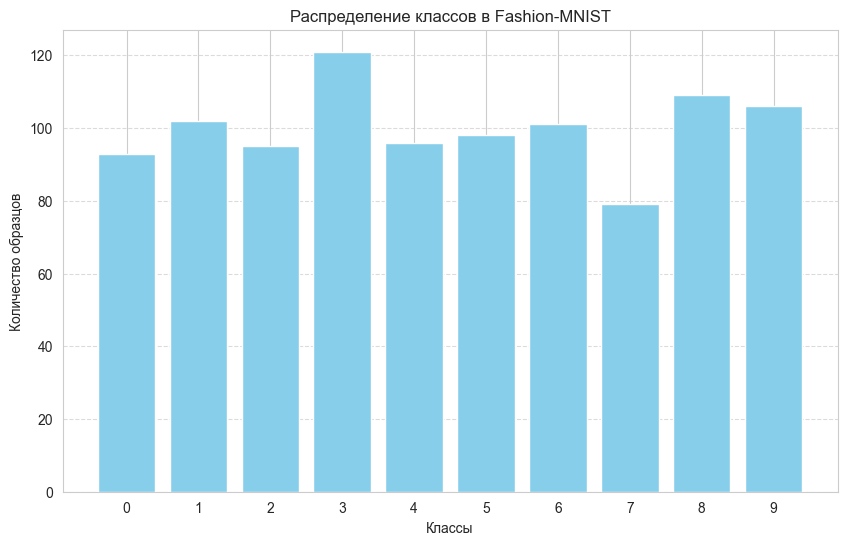

In [8]:
unique_classes, class_counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Классы')
plt.ylabel('Количество образцов')
plt.title('Распределение классов в Fashion-MNIST')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
binary_train_X = X_train[(y_train == '0') | (y_train == '1')]
binary_train_y = y_train[(y_train == '0') | (y_train == '1')]
binary_test_X = X_test[(y_test == '0') | (y_test == '1')]
binary_test_y = y_test[(y_test == '0') | (y_test == '1')]

binary_test_y = binary_test_y.astype(int)
binary_train_y = binary_train_y.astype(int)

print(binary_test_y.astype(int))
print(binary_train_y.astype(int))

[1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0]
[1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1
 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1
 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1
 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 0 0 1]


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [11]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [12]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
print(dists)

[[32969. 31290. 19203. ... 62868. 37755. 19107.]
 [67715. 66710. 62803. ... 24482. 58947. 74821.]
 [26156. 26141. 18322. ... 62289. 33226. 15722.]
 ...
 [20831. 12290. 40173. ... 63980. 42463. 36273.]
 [18078. 14331. 33886. ... 60359. 41702. 31338.]
 [41413. 48004. 29329. ... 53528. 41369. 34099.]]


In [13]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
print(dists)

[[32969. 31290. 19203. ... 62868. 37755. 19107.]
 [67715. 66710. 62803. ... 24482. 58947. 74821.]
 [26156. 26141. 18322. ... 62289. 33226. 15722.]
 ...
 [20831. 12290. 40173. ... 63980. 42463. 36273.]
 [18078. 14331. 33886. ... 60359. 41702. 31338.]
 [41413. 48004. 29329. ... 53528. 41369. 34099.]]


In [14]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
print(dists)

[[32969 31290 19203 ... 62868 37755 19107]
 [67715 66710 62803 ... 24482 58947 74821]
 [26156 26141 18322 ... 62289 33226 15722]
 ...
 [20831 12290 40173 ... 63980 42463 36273]
 [18078 14331 33886 ... 60359 41702 31338]
 [41413 48004 29329 ... 53528 41369 34099]]


Проверим скорость работы реализованных методов

In [15]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

28.4 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.85 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса

In [16]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)

[1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0]


### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [17]:
# TODO: binary_classification_metrics in metrics.py

In [18]:
# binary_classification_metrics(prediction, binary_test_y)

tp, tn, fp, fn, precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Metrics:")
print("\n")
print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)
print("\n")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Metrics:


True positive: 21
True negative: 15
False positive: 0
False negative: 0


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [20]:
precision = precision_score(binary_test_y, prediction)
recall = recall_score(binary_test_y, prediction)
f1 = f1_score(binary_test_y, prediction)
accuracy = accuracy_score(binary_test_y, prediction)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [21]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    train_metrics = []
    test_metrics = []
    
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)

        train_pred = knn_classifier.predict(X_train)
        test_pred = knn_classifier.predict(X_test)

        train_metric_value = metric(y_train, train_pred)
        test_metric_value = metric(y_test, test_pred)

        train_metrics.append(train_metric_value)
        test_metrics.append(test_metric_value)
    
    return train_metrics, test_metrics

In [22]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

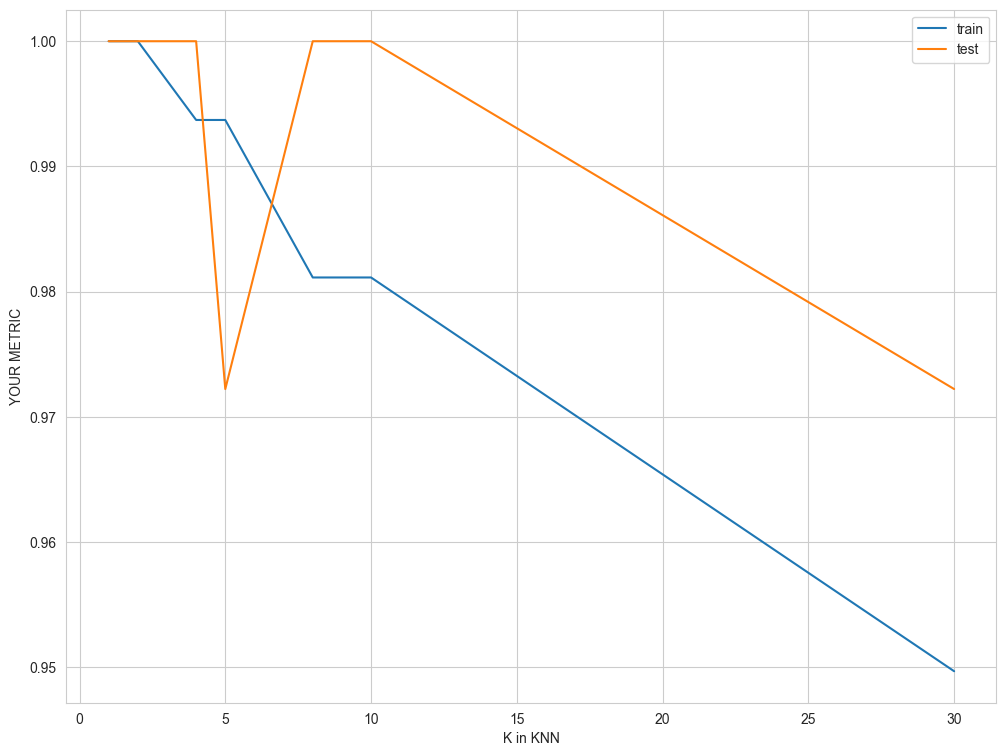

In [23]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

По графику видно, что оптимальное значение k = 1 

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [24]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train.astype(int))
predictions = knn_classifier.predict(X_test)
print(predictions)

[1 5 7 2 0 3 1 7 6 7 0 6 9 4 0 6 8 4 9 7 9 8 1 9 9 9 4 4 0 5 0 7 3 3 2 3 6
 9 3 2 0 0 8 3 2 8 4 3 1 6 9 9 2 4 5 4 1 7 4 8 5 4 1 2 7 1 9 3 7 7 6 9 6 9
 7 8 0 7 2 1 5 3 8 8 9 6 3 3 6 0 3 4 5 9 6 3 7 4 6 5 2 4 5 5 1 0 8 8 1 5 6
 8 6 1 1 1 2 1 2 9 3 9 6 5 0 8 0 5 6 0 2 2 8 2 3 9 9 2 4 8 2 1 0 3 6 8 3 1
 2 5 4 3 9 3 7 0 1 8 0 3 0 8 1 7 5 8 8 9 4 1 7 3 6 9 6 6 2 8 6 2 9 0 5 3 8
 3 2 6 2 9 0 3 1 0 7 3 5 9 9 3]


Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [25]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test.astype(int))

0.77

In [26]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train.astype(int), y_train.astype(int), X_test.astype(int), 
                                          y_test.astype(int), params, accuracy_score)

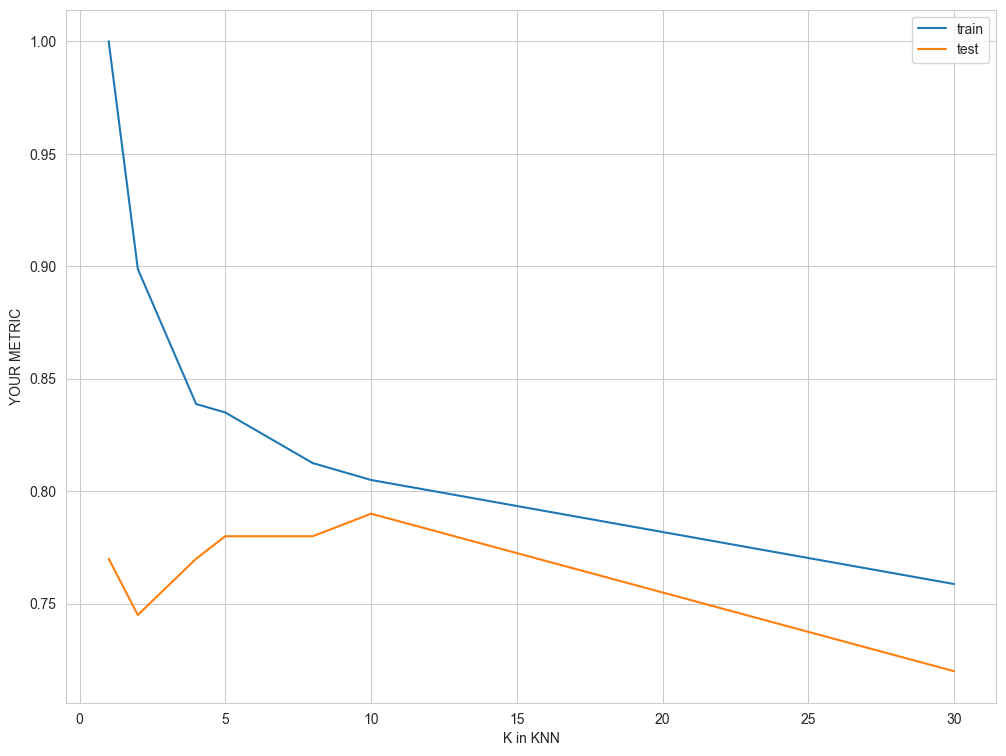

In [27]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

В данной ситуации видно, что оптимальное значение k для многоклассовой классификации сильно отличается от бинарной, в данном случае оно равно 10

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [28]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer

In [29]:
X, y = load_diabetes(as_frame=True, return_X_y=True, scaled = False)

In [30]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [31]:
# EDA
print("Data info:")
print(X.info())
print("\n")

print("Statistics:")
print(X.describe())
print("\n")

print("NAs:")
print(X.isnull().sum())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB
None


Statistics:
              age         sex         bmi          bp          s1          s2  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    48.518100    1.468326   26.375792   94.647014  189.140271  115.439140   
std     13.109028    0.499561    4.418122   13.831283   34.608052   30.413081   
min     19.000000    1.000000   18.000000   62.000000  

#### Перед работой с данными необходимо привести различные данные к одной метрике, так как в противном случае это может привести к "неправильному" обучении модели. Так как при скачивании данных я указала scaled = FALSE, выполним шаг стандартизации с помощью pipeline.

In [32]:
from sklearn.pipeline import Pipeline

In [33]:
# В нашем датасете есть категориальные переменные, преобразуем их с помощью ohe
# Так же создадим Pipeline
cat_cols = ['sex']
num_cols = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  
        ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
    ])

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', KNeighborsRegressor(n_neighbors=4))  
])

In [34]:
# Разобьем датасет на тестовый и трейн:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [35]:
pipeline_knn.fit(X_train, y_train)

y_pred_knn = pipeline_knn.predict(X_test)

print(y_pred_knn)

[210.75 125.75 163.   135.75 137.   182.   140.5  106.    89.    58.75
 119.   233.25 213.   232.25 165.75 161.   166.25 124.75 204.5   73.
  82.25 167.25 160.25 206.75  79.5  116.    59.25 110.75 231.25 114.25
 170.25 119.5  148.25 163.   101.25 125.5   73.75 126.75 199.5  117.
 142.   298.   140.5  112.5  154.75  98.   174.    59.5  178.   199.5
 170.75 238.25 223.   120.5  225.75  96.5   92.25 195.5   57.    81.
  82.   106.5  170.25 109.75 284.   145.75  77.    97.75 264.25 175.
 148.75 189.   100.75 174.75 122.   139.25  80.25 130.75 126.5  119.5
 141.25 105.75 257.75 111.5  149.    84.   129.   117.   103.25]


### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [36]:
from metrics import r_squared, mse, mae

print("Metrics:")
print("R^2:", r2_score(y_test, y_pred_knn))
print("MSE:", mean_squared_error(y_test, y_pred_knn))
print("MAE:", mean_absolute_error(y_test, y_pred_knn))

Metrics:
R^2: 0.29669874061827817
MSE: 3305.830056179775
MAE: 44.58426966292135


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

In [37]:
def find_best_k_reg(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    train_metrics = []
    test_metrics = []
    
    for k in params:
        knn_regressor = KNeighborsRegressor(n_neighbors=k)
        knn_regressor.fit(X_train, y_train)
        
        train_pred = knn_regressor.predict(X_train)
        test_pred = knn_regressor.predict(X_test)

        train_metric_value = metric(y_train, train_pred)
        test_metric_value = metric(y_test, test_pred)

        train_metrics.append(train_metric_value)
        test_metrics.append(test_metric_value)
    
    return train_metrics, test_metrics

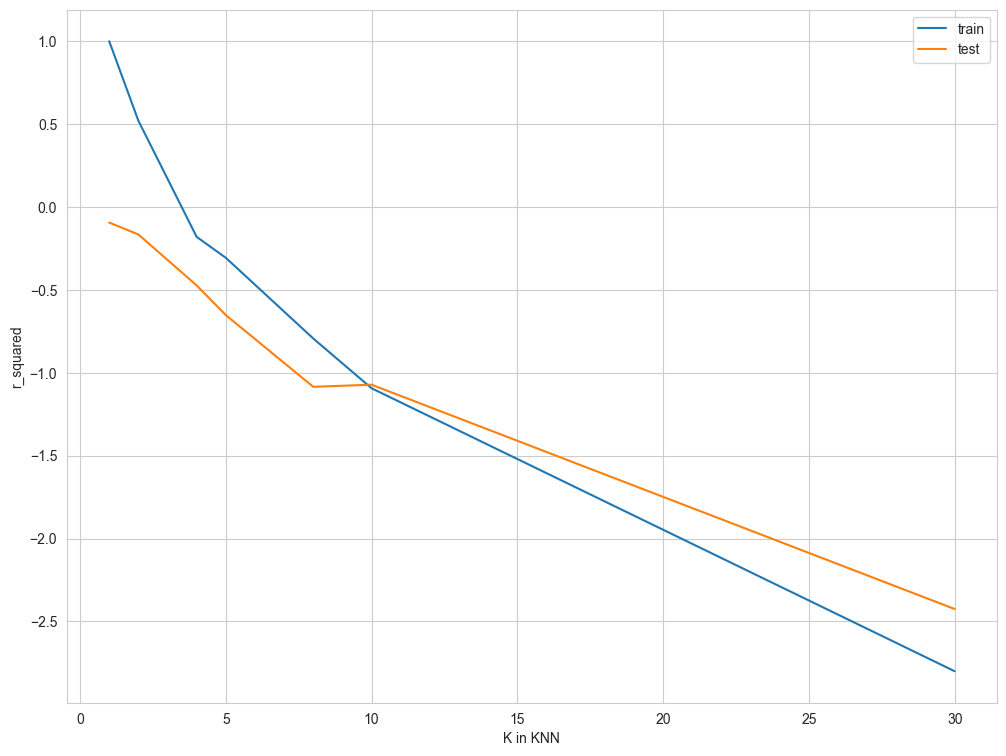

In [38]:
# Для r_squared
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k_reg(X_train, y_train, X_test, y_test, params, r_squared)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("r_squared");

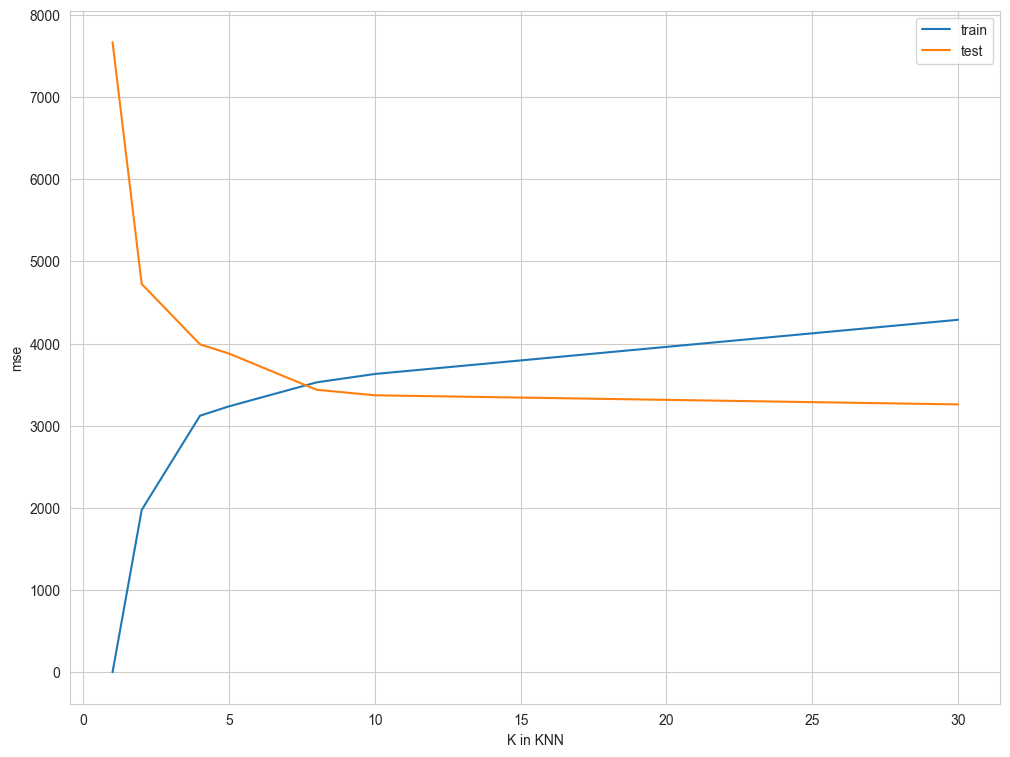

In [39]:
# Для mse
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k_reg(X_train, y_train, X_test, y_test, params, mse)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("mse");

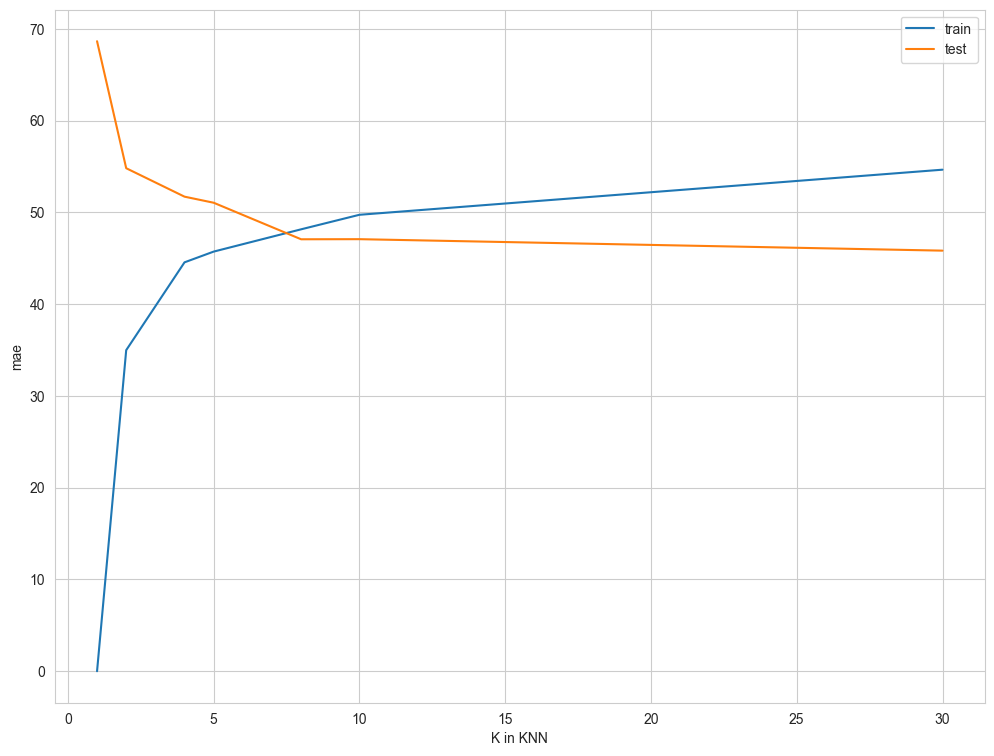

In [40]:
# Для mae
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k_reg(X_train, y_train, X_test, y_test, params, mae)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("mae");

Таким образом, лучший k = 7 и 10

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

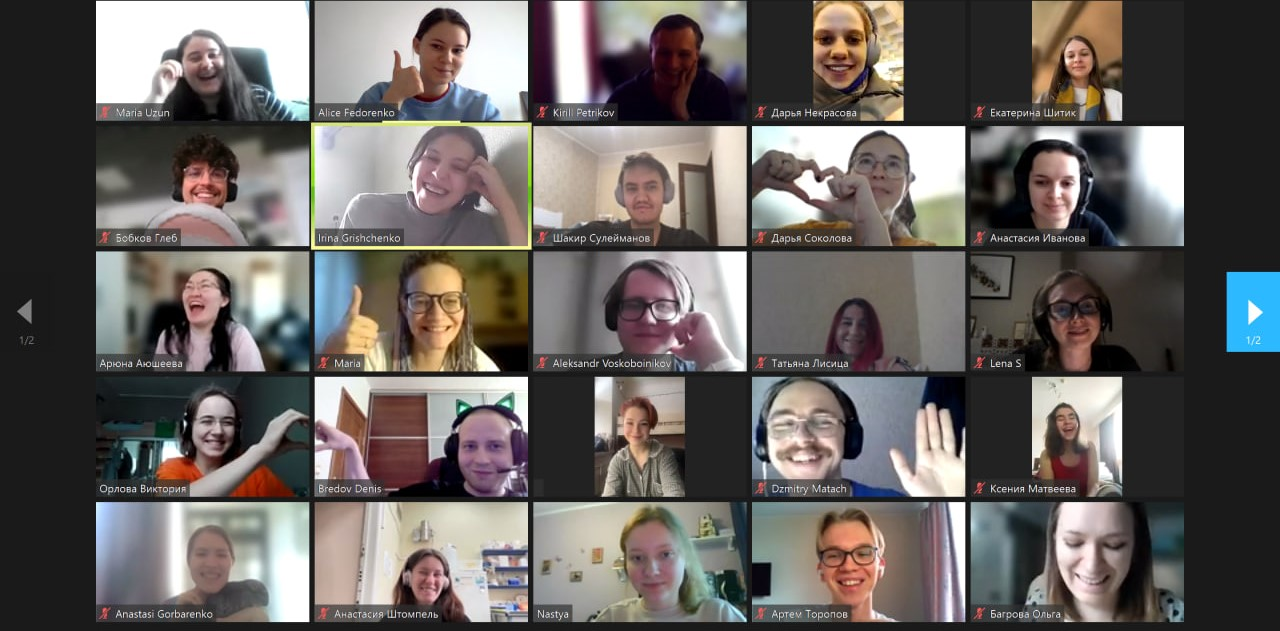

In [41]:
from IPython.display import Image

image_path = "./photo.jpg"

Image(filename=image_path)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**
После лекции, консультации и домашки стала понятна логика обучения, тренировки модели, чтобы она наконец-то что-то предсказала, потому что я обычно к тарологу обращаюсь в таких ситуациях. В первом задании, так как мы работали с картинками не были очевидны некоторые вещи, например, что переменные надо переводить в интеджеры, и пока до меня это не дошло, было тяжко. Наверное, по ходу первого задания хотелось больше подсказок или материалов, потому что где-то некоторые моменты так и остались не до конца понятными, или же на решение чего-то одного ушло слишком много времени (но наверное так и должно было быть). В общем, опыт хороший, надеюсь, после такой домашки уже учиться будут машинки :D